In [1]:
using DataFrames
using Gadfly
set_default_plot_size(30cm, 12cm)
home = "/home/german/labo/18/lbp/run"

"/home/german/labo/18/lbp/run"

In [2]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

get_κ (generic function with 1 method)

In [3]:
function dist_mode(freq::Float64)
    # Declaro cte de boltzmann, avogadro, y temperatura.
    Kb = 1.38064852e-23
    A = 6.0221409e+23
    T = 298
    AKbT = A * Kb * T
    
    return d^2 * 0.5 * KBT * evals.^2 / cte # KJ/mol
end

get_pnum (generic function with 1 method)

In [7]:
function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831
    
    return d^2 * 0.5 * KBT * sum(evals.^2 .* gdte.^2) / cte # KJ/mol
end

energia_gdte (generic function with 2 methods)

In [8]:
function energia_modes(evals::Array{Float64, 1}, d::Float64 = 1.)
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831

    return d^2 * 0.5 * KBT * sum(evals.^2) / cte # KJ/mol
end

energia_modes (generic function with 2 methods)

In [9]:
function E_modes_wvgv(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831
    
    return d^2 * 0.5 * KBT * (evals.^2 .* gdte.^2) / cte # KJ/mol
end

E_modes_wvgv (generic function with 2 methods)

In [10]:
function E_modes(evals::Array{Float64, 1}, d::Float64 = 1.)
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831
    
    return d^2 * 0.5 * KBT * evals.^2 / cte # KJ/mol
end

E_modes (generic function with 2 methods)

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [17]:
pdb = "1ael"
# Leo modos
sym_mode = Symbol("modes_", pdb)
sym_eval = Symbol("evals_", pdb)
tmp_mode, tmp_eval = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))
eval(:($sym_mode = $tmp_mode))
eval(:($sym_eval = $tmp_eval))

# Leo volúmenes originales
sym_vol = Symbol("vol_avg_", pdb)
tmp_vol = convert(Float64,
    readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])
eval(:($sym_vol = $tmp_vol))

# Leo volúmenes NDD
sym_ndd_out = Symbol("ndd_out_", pdb)
tmp_ndd_out = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])
eval(:($sym_ndd_out = $tmp_ndd_out))

# VGV
sym_vgv = Symbol("vgv_", pdb)
tmp_vgv = eval(:($sym_ndd_out .- $sym_vol))
eval(:($sym_vgv = $tmp_vgv ./ norm($tmp_vgv)));

### Obtiene los pnum modos y pnum eigenvals

In [16]:
# Obtengo pnum de los VGV
pdb = "1ael"
# Pnumber de VGV
sym_pnu = Symbol("pnu_", pdb)
sym_vgv = Symbol("vgv_", pdb)
tmp_pnu = eval(:(get_pnum($sym_vgv)))
eval(:($sym_pnu = $tmp_pnu))

# Pnumber indices
sym_idx = Symbol("idx_pnu_", pdb)
eval(:($sym_idx = sortperm(abs.($sym_vgv), rev=true)[1:$tmp_pnu]))

# Pnumber modes
sym_modes = Symbol("modes_", pdb)
sym_pnu_modes = Symbol("pnu_modes_", pdb)
eval(:($sym_pnu_modes = $sym_modes[:, $sym_idx]))

# Pnumber eigenvalues
sym_evals = Symbol("evals_", pdb)
sym_pnu_evals = Symbol("pnu_evals_", pdb)
eval(:($sym_pnu_evals = $sym_evals[$sym_idx]))

# VGV cartesiano
sym_xyz_vgv = Symbol("xyz_vgv_", pdb)
eval(:($sym_xyz_vgv = tognm($sym_modes * $sym_vgv)))

# Pnumber aminoácidos según VGV (aminoácidos de la pared)
sym_aa_pnu_ = Symbol("aa_pnu_", pdb)
eval(:($sym_aa_pnu_ = get_pnum($sym_xyz_vgv)))

# Índices de pnumber aminoácidos
sym_idx_pnu_aa = Symbol("idx_pnu_aa_", pdb)
eval(:($sym_idx_pnu_aa = sortperm(abs.($sym_xyz_vgv), rev = true)[1:$sym_aa_pnu_]))

# Todos los modos recortados según pnumber aminoácidos
sym_modes_cut = Symbol("modes_cut_", pdb)
eval(:($sym_modes_cut = $sym_modes[$sym_idx_pnu_aa, :]))
# Normalizo
eval(:($sym_modes_cut = mapslices(x -> x ./ norm(x), $sym_modes_cut, 1)))

# Pnum modos recortados según pnumber aminoácidos
sym_pnu_modes_cut = Symbol("pnu_modes_cut_", pdb)
eval(:($sym_pnu_modes_cut = $sym_pnu_modes[$sym_idx_pnu_aa, :]))
# Normalizo
eval(:($sym_pnu_modes_cut = mapslices(x -> x ./ norm(x), $sym_pnu_modes_cut, 1)))

### κ

In [ ]:
# Colectividad de modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_1ael, 1), 1)))
κ_modes_1ael = reshape(tmp, length(tmp))))

# Colectividad de pnum modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), pnu_modes_1ael, 1), 1)))
κ_modes_pnu_1ael  = reshape(tmp, length(tmp))

# Colectividad de modos recortados
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_cut_1ael, 1), 1)))
κ_modes_cut_1ael  = reshape(tmp, length(tmp))

# Colectividad de pnum modos recortados
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), pnu_modes_cut_1ael, 1), 1)))
κ_modes_pnu_cut_1ael = reshape(tmp, length(tmp))

### Pnumber

In [23]:
# Pnumber de modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_1ael, 1), 1)
col_pnu_modes_1ael = reshape(tmp, length(tmp))

# Pnumber de pnum modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), pnu_modes_1ael, 1), 1)
col_pnu_modes_pnu_1ael = reshape(tmp, length(tmp))

# Pnumber de modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_cut_1ael, 1), 1)
col_pnu_modes_cut_1ael = reshape(tmp, length(tmp))

# Pnumber de pnum modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), pnu_modes_cut_1ael, 1), 1)
col_pnu_modes_pnu_cut_1ael = reshape(tmp, length(tmp));

120×354 Array{Float64,2}:
 0.0392173  0.0362968   0.057884   …  0.0133437   0.00632227  0.0096777 
 0.0116093  0.0225659   0.0462783     0.00738409  0.00121345  0.00917448
 0.0296691  0.0504355   0.0546253     0.00785316  0.00488756  0.00153153
 0.0264004  0.0546445   0.0537241     0.00777114  0.00435974  0.00522233
 0.0733736  0.0702978   0.0473457     0.00663126  0.00287851  0.00456101
 0.116222   0.0585328   0.0349934  …  0.00357915  0.002243    0.00353454
 0.16283    0.0382501   0.0409614     0.00341727  0.00346713  0.00230766
 0.117726   0.0301613   0.0350648     0.0189071   0.0063438   0.00802488
 0.106237   0.0193165   0.036609      0.0199488   0.00617709  0.0115135 
 0.147022   0.0202239   0.0491286     0.0146474   0.0019469   0.0111246 
 0.133506   0.0191533   0.0525411  …  0.0061819   0.00557031  0.00627115
 0.0919158  0.0305276   0.0494146     0.0103209   0.00704296  0.00260126
 0.115152   0.0307968   0.0572728     0.0110969   0.01149     0.00168571
 ⋮                       

# Frecuencia

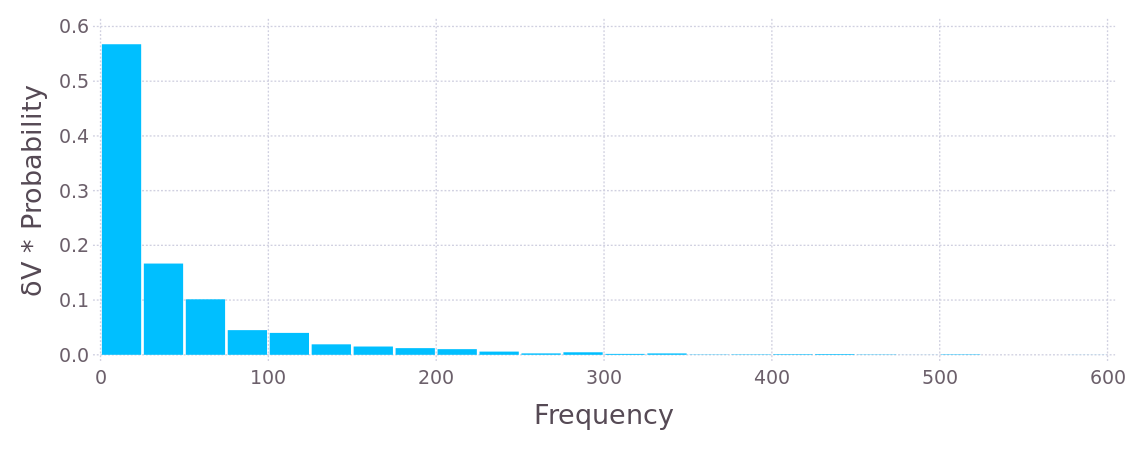

In [15]:
# Los bins van de 0 a la fqcia más alta + 10%
top_evals = maximum(evals_1ael)
bins_evals = collect(0:25:top_evals)

# Histograma ponderado
Whis_evals_1ael, Wbins_evals_1ael = WeightedHist(evals_1ael, bins_evals, abs.(vgv_1ael), true);
df_Whis_evals_1ael = DataFrame(Probability = Whis_evals_1ael, Frequency = Wbins_evals_1ael);


pdf_Whis_evals_1ael = plot(df_Whis_evals_1ael, x="Frequency", y="Probability", Geom.bar,
    #Guide.title("Figure 1.A"),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Colectividad

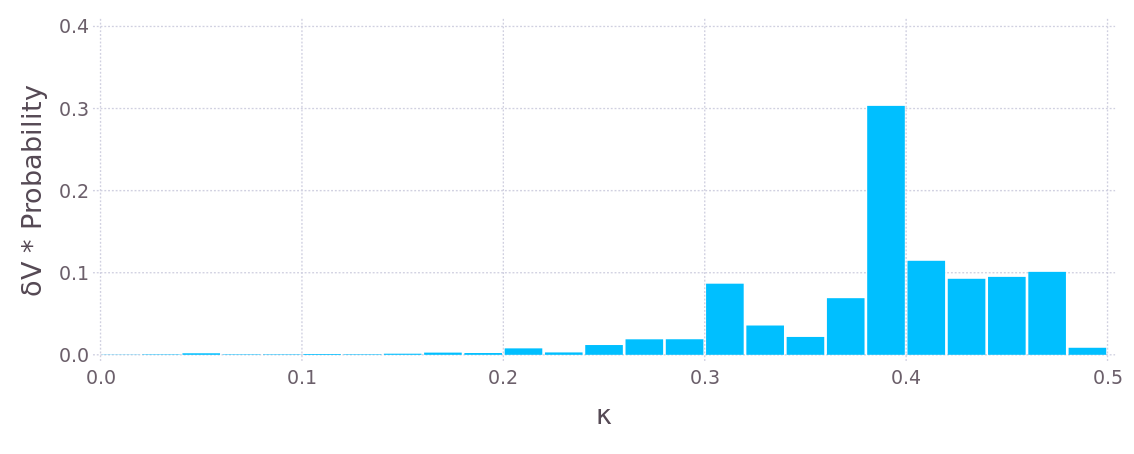

In [20]:
# Los bins van de 0 a la fqcia más alta + 10%
top_κ = maximum(κ_1ael)
bins_κ = collect(0:.02:top_κ)

# Histograma ponderado
Whis_κ_1ael, Wbins_κ_1ael = WeightedHist(κ_1ael, bins_κ, abs.(vgv_1ael), true);
df_Whis_κ_1ael = DataFrame(Probability = Whis_κ_1ael, κ = Wbins_κ_1ael);

pdf_Whis_κ_1ael = plot(df_Whis_κ_1ael, x="κ", y="Probability", Geom.bar,
    #Guide.title("Figure 1.A"),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Colectividad en pnumber

### Modos enteros

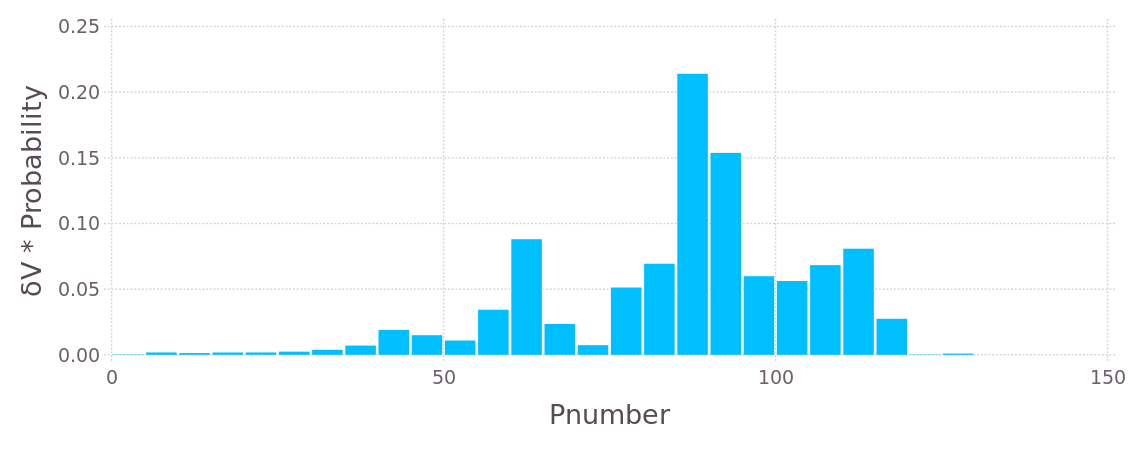

In [20]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_pnu_modes_1ael)
bins_col = collect(0:5:top_col)

# Histograma ponderado
Whis_col_1ael, Wbins_col_1ael = WeightedHist(col_pnu_modes_1ael, bins_col, abs.(vgv_1ael), true);
df_Whis_col_1ael = DataFrame(Probability = Whis_col_1ael, Pnumber = Wbins_col_1ael);

pdf_Whis_col_1ael = plot(df_Whis_col_1ael, x="Pnumber", y="Probability", Geom.bar,
    #Guide.title("Figure 1.A"),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

### Modos recortados

In [ ]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_pnu_modes_cut_1ael)
bins_col = collect(0:2:top_col)

# Histograma ponderado
    Whis_col_cut_1ael, Wbins_col_cut_1ael = WeightedHist(col_pnu_modes_cut_1ael, bins_col, abs.(vgv_1ael), true);
df_Whis_col_cut_1ael = DataFrame(Probability = Whis_col_cut_1ael, Pnumber = Wbins_col_cut_1ael);

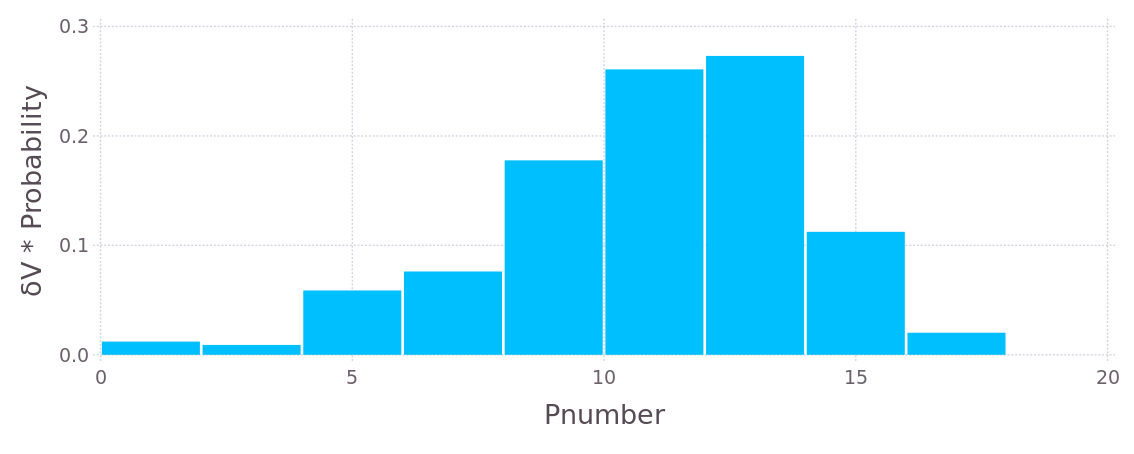

In [19]:
pdf_Whis_col_cut_1ael = plot(df_Whis_col_cut_1ael, x="Pnumber", y="Probability", Geom.bar,
    #Guide.title("Figure 1.A"),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# AAs de la pared

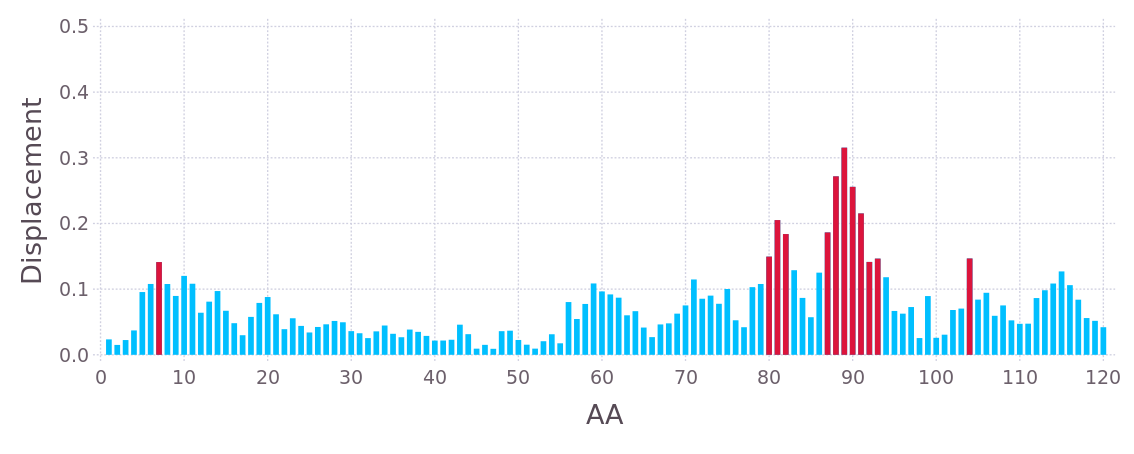

In [78]:
tmp = abs.(xyz_vgv_1ael)
tmp_ = copy(tmp)
tmp_[tmp_ .< .13] .= 0.

layer_temp_1 = layer(DataFrame(Displacement = tmp), Geom.bar, y = "Displacement")
layer_temp_2 = layer(DataFrame(Displacement = tmp_), Geom.bar, y = "Displacement",
Theme(default_color=colorant"crimson", bar_spacing=2pt))


pdf_cart_gdte = plot(layer_temp_2, layer_temp_1,
    Guide.xlabel("AA"),
    Guide.ylabel("Displacement"), Coord.cartesian(ymax = 0.5),
    Guide.xticks(ticks=collect(0:10:120)),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
        key_label_font_size = 15pt))